In [12]:
from utils import auto_wonder_2018_pipeline

df = auto_wonder_2018_pipeline(
    observed_outcome=[
        "Diseases of the circulatory system",
        "Diseases of the respiratory system",
    ],
    short_outcome=["circulatory system", "respiratory system"],
)

df

/Users/arnaudpetit/Documents/Programmation/MIT/arnaud/utils/pipeline/cdc_wonder_2018.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_outcomes_["MMWR Week"]
/Users/arnaudpetit/Documents/Programmation/MIT/arnaud/utils/pipeline/cdc_wonder_2018.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_outcomes_["MMWR Week"]


cirdeaths       date  resdeaths  totaldeaths
state time       category                                              
AK    2018-01-06 65+            11.0 2018-01-06        0.0         11.0
                 all            15.0 2018-01-06        0.0         15.0
      2018-01-13 65+            16.0 2018-01-13        0.0         16.0
                 all            20.0 2018-01-13       12.0         32.0
      2018-01-20 65+            18.0 2018-01-20        0.0         18.0
...                              ...        ...        ...          ...
WY    2022-05-07 all            15.0 2022-05-07        0.0         15.0
      2022-05-14 65+            15.0 2022-05-14        0.0         15.0
                 all            15.0 2022-05-14        0.0         15.0
      2022-05-21 65+            13.0 2022-05-21        0.0         13.0
                 all            18.0 2022-05-21        0.0         18.0

[23344 rows x 4 columns]

In [21]:
from countries_code import code
import pandas as pd

data_ = pd.read_excel("data/ml.xlsx", sheet_name=None)

key_mapper = {
    "FEMA - Major Disaster - Fire": "fire",
    "FEMA - Major Disaster - Earthqu": "earthquake",
    "FEMA - Major Disaster - Hurrica": "hurricane",
    "FEMA - Major Disaster - Tornado": "tornado",
    "FEMA - Major Disaster - Flood": "flood",
}
data_ = {key_mapper.get(old_key, old_key): value for old_key, value in data_.items()}

df_disaster = data_["fire"].loc[:, ["State", "Declaration Date", "Incident Type"]]

df_disaster["State"] = df_disaster["State"].map(code)
df_disaster = df_disaster.dropna()
df_disaster = df_disaster[df_disaster["Declaration Date"] > "2019"]
len(df_disaster)

8

In [22]:
from utils import process_data_rd, filter


df_temporel = {
    (date, state): {
        category: process_data_rd(
            df.loc[(slice(None), slice(None), category)],
            state=state,
            disaster_date=date,
        )
        for category in df.index.unique(level="category")
    }
    for date, state in zip(df_disaster["Declaration Date"], df_disaster["State"])
}


In [23]:
import statsmodels.api as sm

import numpy as np

from typing import List


def hist(sx: List[float]):
    """
    Histogram from list of samples
    """

    d = dict()
    for s in sx:
        d[s] = d.get(s, 0) + 1
    return d


converter_ = lambda dict_: (
    np.array(list(dict_.keys())),
    np.array(list(dict_.values())),
)

test = list(df_temporel.values())[8]
x = test.cirdeaths.astype(int)


x_post = x[(x.index > 0) & (x.index < 12 * 30)]
x_prior = x[(x.index < 0) & (x.index > -12 * 30)]

x_ = {"prior": x_prior, "post": x_post}
hist_ = {k: converter_(hist(v)) for k, v in x_.items()}

fit_ = {key: sm.NegativeBinomial(*v).fit() for key, v in hist_.items()}

statistics__ = lambda mu, lambda_: {
    "r": 1 / lambda_,
    "p": 1 / (1 + np.exp(mu) * lambda_),
}
scores_likehood = {k: v.llf for k, v in fit_.items()}
parameters_likehood = {k: statistics_(*(v.params)) for k, v in fit_.items()}

for key, score in scores_likehood.items():
    print("Log Likehood estimator {} {}".format(key, score))

IndexError: list index out of range

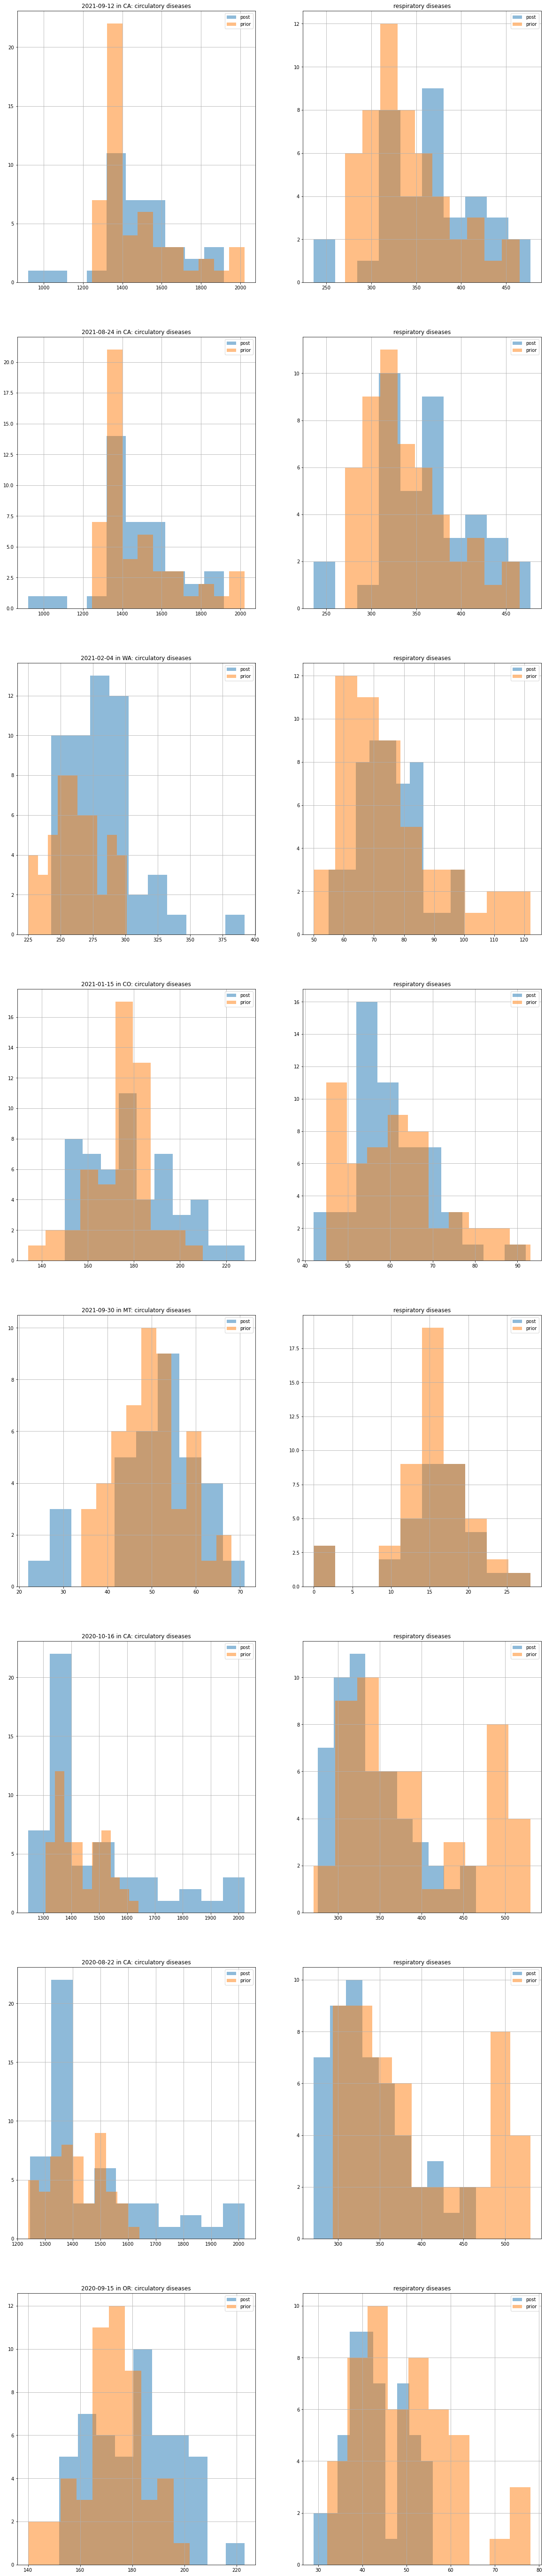

In [24]:
import matplotlib.pyplot as plt

# return (p,r) moment estimation
statistics_ = lambda mean, var: {
    "r": mean ** 2 / (var - mean),
    "p": mean / var,
}


split_event = lambda df: (
    df[(df.index > 0) & (df.index < 12 * 30)],
    df[(df.index < 0) & (df.index > -12 * 30)],
)

n_events = len(df_temporel)
n_categories = len(next(iter(df_temporel)))

fig, axs = plt.subplots(n_events, n_categories, figsize=(20, 100))

for index, (meta, df_dict) in enumerate(df_temporel.items()):
    time, location = meta
    date = str(time).split(" ")[0]
    
    df_ = df_dict['65+']
    x, y = df_.cirdeaths.astype(int), df_.resdeaths.astype(int)
    x_post, x_prior = split_event(x)
    y_post, y_prior = split_event(y)

    x_post.hist(ax=axs[index, 0], label="post", alpha=0.5)
    x_prior.hist(ax=axs[index, 0], alpha=0.5, label="prior")

    y_post.hist(ax=axs[index, 1], label="post", alpha=0.5)
    y_prior.hist(ax=axs[index, 1],label="prior", alpha=0.5)
    
    
        # pandas method with bias n-1 correction
    #moments_ = {key: (data.mean(), data.var()) for key, data in x_.items()}
  # estimate (r,p)
    #parameters_moments = {k: statistics_(*v) for k, v in moments_.items()}
    
    axs[index, 0].legend()
    axs[index, 0].set_title(f"{date} in {location}: circulatory diseases")
    axs[index, 1].legend()
    axs[index, 1].set_title("respiratory diseases")
    
plt.legend()